In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans, DBSCAN
from skimage import io
import os
import tqdm
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

In [5]:
list_dir = os.listdir('data')
list_dir

['KRA_ADMIN_100m.tif',
 'KRA_LANDCOVER_100m.tif',
 'KRA_PREC_100m.tif',
 'KRA_RELIEF_ASPECT_100m.tif',
 'KRA_RELIEF_HEIGHT_100m.tif',
 'KRA_RELIEF_SLOPE_100m.tif',
 'KRA_SOILTEXTURE_100m.tif',
 'KRA_SUNNY_DAYS_APR_OCT_100m.tif',
 'KRA_TAVG_100m.tif',
 'KRA_TMAX_100m.tif',
 'KRA_TMIN_100m.tif',
 'KRA_VINEYARDS_100m.tif',
 'KRA_WATER_SEASONALYTY_100m.tif',
 'README.txt',
 'VINEYARDS.geojson',
 'VINEYARDS.TXT']

# area clustering

In [10]:
img = io.imread('data/KRA_VINEYARDS_100m.tif')

In [11]:
xy = np.vstack(np.where(img)).T

In [12]:
xy = xy / 4095

In [24]:
clf = KMeans(216)

In [25]:
%%time
label = clf.fit_predict(xy)

CPU times: total: 40.9 s
Wall time: 5.16 s


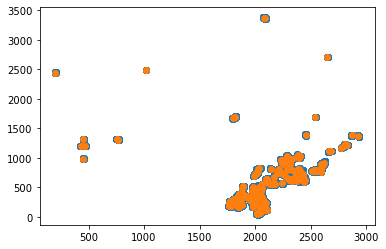

In [182]:
plt.scatter(xy[:,0]*4095, xy[:,1]*4095)
plt.scatter(clf.cluster_centers_[:,0]*4095, clf.cluster_centers_[:,1]*4095)

In [61]:
xy_data = pd.DataFrame(xy, columns = ['x', 'y']) 

In [62]:
xy_data['label'] = label

In [63]:
xy_data['x'] = (xy_data['x']*4095).astype(np.int32)
xy_data['y'] = (xy_data['y']*4095).astype(np.int32)

# clustering information to need terretory

In [171]:
num_data = ['KRA_RELIEF_ASPECT_100m.tif',
            'KRA_RELIEF_HEIGHT_100m.tif',
            'KRA_RELIEF_SLOPE_100m.tif',
            'KRA_SUNNY_DAYS_APR_OCT_100m.tif',
           'KRA_WATER_SEASONALYTY_100m.tif']

num_many_chanel_data = ['KRA_TAVG_100m.tif',
            'KRA_TMIN_100m.tif',
            'KRA_TMAX_100m.tif',
            'KRA_PREC_100m.tif']
path_to_save = 'to_save/'
cat_data = ['KRA_SOILTEXTURE_100m.tif']
path = 'data/'
uniq_label = np.unique(label)

#num feat
for name in num_data:
    img_tmp = io.imread(path + name).astype(np.float32)
    name_for_write = name.split('.')[0]
    res_list = []
    for cluster in tqdm.tqdm(uniq_label):
        res_dict = {}
        res_dict['index_cluster'] = cluster
        xy_tmp = xy_data[xy_data['label'] == cluster][['x', 'y']].values
        x, y = xy_tmp[:,0], xy_tmp[:,1]
        pixel_wise_value = img_tmp[x,y]
        min_val, max_val, mean_val = pixel_wise_value.min(), pixel_wise_value.max(), pixel_wise_value.mean()
        res_dict['min_value_' + name_for_write] = min_val
        res_dict['max_value_' + name_for_write] = max_val
        res_dict['mean_value_' + name_for_write] = mean_val
        res_list.append(res_dict)
    df_res = pd.DataFrame(res_list, dtype = np.float64)
    df_res.to_csv(path_to_save + name_for_write + '.csv', index = False)



100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 2181.16it/s]


In [172]:
#many chanel data
for name in num_many_chanel_data:
    img_tmp_ = io.imread(path + name).astype(np.float32)
    name_for_write = name.split('.')[0]
    res_list = []
    img_tmp = img_tmp_[:,:,chanel]
    for cluster in tqdm.tqdm(uniq_label):
        res_dict = {}
        res_dict['index_cluster'] = cluster
        for chanel in range(img_tmp_.shape[2]):

            xy_tmp = xy_data[xy_data['label'] == cluster][['x', 'y']].values
            x, y = xy_tmp[:,0], xy_tmp[:,1]
            pixel_wise_value = img_tmp[x,y]
            min_val, max_val, mean_val = pixel_wise_value.min(), pixel_wise_value.max(), pixel_wise_value.mean()
            res_dict['min_value_' + name_for_write + '_chanel_' + str(chanel)] = min_val
            res_dict['max_value_' + name_for_write + '_chanel_' + str(chanel)] = max_val
            res_dict['mean_value_' + name_for_write + '_chanel_' + str(chanel)] = mean_val
        res_list.append(res_dict)
    df_res = pd.DataFrame(res_list, dtype = np.float64)
    df_res.to_csv(path_to_save + name_for_write + '.csv', index = False)

100%|███████████████████████████████████████████████████████████████████████████████| 216/216 [00:01<00:00, 181.29it/s]


In [173]:
for name in cat_data:
    img_tmp = io.imread(path + name).astype(np.float32)
    name_for_write = name.split('.')[0]
    res_list = []
    uniq_val = np.unique(img_tmp)
    
    for cluster in tqdm.tqdm(uniq_label):
        res_dict = {}
            
        res_dict['index_cluster'] = cluster
        xy_tmp = xy_data[xy_data['label'] == cluster][['x', 'y']].values
        x, y = xy_tmp[:,0], xy_tmp[:,1]
        pixel_wise_value = img_tmp[x,y]
        c = Counter(pixel_wise_value)
        for v in uniq_val:
            res_dict['count_of_' + str(v)] = c[v]
        res_list.append(res_dict)
            
    df_res = pd.DataFrame(res_list)
    df_res.to_csv(path_to_save + name_for_write + '.csv')

100%|██████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 2056.69it/s]


In [174]:
list_dir = os.listdir('to_save')

In [175]:
all_df = pd.DataFrame(label, columns = ['index_cluster'])
for f in list_dir:
    try:
        df = pd.read_csv('to_save/' + f)
    except:
        continue
        
    all_df = all_df.merge(df, on = 'index_cluster')


In [176]:
len([x for x in all_df.columns if 'mean' in x])

41

In [179]:
[x for x in all_df.columns if 'mean' in x]

['mean_value_KRA_RELIEF_ASPECT_100m',
 'mean_value_KRA_RELIEF_HEIGHT_100m',
 'mean_value_KRA_RELIEF_SLOPE_100m',
 'mean_value_KRA_SUNNY_DAYS_APR_OCT_100m',
 'mean_value_KRA_TAVG_100m_chanel_0',
 'mean_value_KRA_TAVG_100m_chanel_1',
 'mean_value_KRA_TAVG_100m_chanel_2',
 'mean_value_KRA_TAVG_100m_chanel_3',
 'mean_value_KRA_TAVG_100m_chanel_4',
 'mean_value_KRA_TAVG_100m_chanel_5',
 'mean_value_KRA_TAVG_100m_chanel_6',
 'mean_value_KRA_TAVG_100m_chanel_7',
 'mean_value_KRA_TAVG_100m_chanel_8',
 'mean_value_KRA_TAVG_100m_chanel_9',
 'mean_value_KRA_TAVG_100m_chanel_10',
 'mean_value_KRA_TAVG_100m_chanel_11',
 'mean_value_KRA_TMAX_100m_chanel_0',
 'mean_value_KRA_TMAX_100m_chanel_1',
 'mean_value_KRA_TMAX_100m_chanel_2',
 'mean_value_KRA_TMAX_100m_chanel_3',
 'mean_value_KRA_TMAX_100m_chanel_4',
 'mean_value_KRA_TMAX_100m_chanel_5',
 'mean_value_KRA_TMAX_100m_chanel_6',
 'mean_value_KRA_TMAX_100m_chanel_7',
 'mean_value_KRA_TMAX_100m_chanel_8',
 'mean_value_KRA_TMAX_100m_chanel_9',
 'mean

In [162]:
df = pd.read_csv('to_save/' + f)

NameError: name 'tmp_img' is not defined